# TDCOSMO sample
This notebook compiles the TDCOSMO sample. It uses the 1d Ddt posteriors from the power-law models and re-processes the kinematics to allow for an explicit treatment of the kinematic assumptions in a hierarchical way.

The first part is to re-compute the kinematics to derive a covariance matrix to be used in the hierarchical analysis. The second part performs the hierarchical sampling of the mass profile and cosmological parameters for the TDCOSMO sample.

Requirements:
- lenstronomy (https://github.com/sibirrer/lenstronomy)
- hierarc (https://github.com/sibirrer/hierArc)

Author: Simon Birrer (sibirrer@gmail.com)



In [1]:
from hierarc.LensPosterior.ddt_kin_constraints import DdtKinConstraints
from hierarc.Sampling.mcmc_sampling import MCMCSampler
import corner
import emcee
import numpy as np
import pickle
import copy
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sklearn
from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)


In [2]:
# names of the TDCOSMO lenses
TDCOSMO_lenses = ['B1608+656', 'RXJ1131-1231', 'HE0435-1223', 'SDSS1206+4332', 'WFI2033-4723', 'PG1115+080', 'DES0408-5354']

# set relative paths to working directory and data
dir_path = os.getcwd()
path2processed = dir_path

# file containing the meta-data of all the lenses (i.e. redshifts and marginal lens model parameter posteriors)
table_name = 'tdcosmo_sample.csv'

table_file_path = os.path.join(dir_path, table_name)
path2posteriors = os.path.join(dir_path, 'TDCOSMO_data')

In [3]:
# numerical settings (not needed if power-law profiles with Hernquist light distribution is computed)
kwargs_numerics_galkin = {'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

anisotropy_model = 'OM'  # 'OM' or 'GOM'

# the kinematics has already been pre-processed and saved. If you want to redo it for a (partial) sample, you can add those to the list
recompute_lenses = [] # ['B1608+656', 'RXJ1131-1231', 'HE0435-1223', 'SDSS1206+4332', 'WFI2033-4723', 'PG1115+080', 'DES0408-5354']

# number of draws from the lens model posterior to compute the kinematics
num_sample_model = 100  # number of kinematics to be computed from the lensing posterior to compute the covariance matrix for a single slit observation (single Gaussian) 
num_sample_model_multi_obs = 200  # to calculate the covariance matrix between multiple observations, more samples are needed than for a single data point

In [4]:

def process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model):
    """
    :param name: string, name of lens according to the csv file
    :param ddt_samples: numpy array, Ddt posteriors
    :param ddt_weights: numpy array or None, individual weights of the posteriors
    :param kappa_pdf: numpy array, probability density of p(kappa)
    :param kappa_bin_edges: numpy array, bin edges of kappa_pdf
    :param num_sample_model: integer, number of draws from the posterior to sample the kinematics prediction covariance matrix
    """
    with open(table_file_path, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            name_lens = row['name']
            if name_lens == name:
                z_lens = float(row['z_lens'])
                kwargs = {'z_lens': float(row['z_lens']), 'z_source': float(row['z_source']),
                                'r_eff': float(row['r_eff']), 'r_eff_error': float(row['r_eff_error']),
                                'theta_E': float(row['theta_E']), 'theta_E_error': float(row['theta_E_error']),
                                'gamma': float(row['gamma']), 'gamma_error': float(row['gamma_error'])}
                kwargs_lens_light, MGE_light, kwargs_mge_light = None, False, None

                kwargs_aperture = {'aperture_type': 'slit', 'length': float(row['slit_length']), 'width': float(row['slit_width']), 'center_ra': 0.0, 'center_dec': 0, 'angle': 0}
                kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': float(row['psf_fwhm'])}

                sigma_v = [float(row['sigma_v'])]
                sigma_v_error_independent = [float(row['sigma_v_error'])]
                ddt_kin = DdtKinConstraints(ddt_samples=ddt_samples, ddt_weights=ddt_weights,
                                 sigma_v=sigma_v, 
                                 sigma_v_error_independent=sigma_v_error_independent, 
                                 sigma_v_error_covariant=0, 
                                 kwargs_aperture=kwargs_aperture, kwargs_seeing=kwargs_seeing, 
                                 kwargs_numerics_galkin=kwargs_numerics_galkin, 
                                 anisotropy_model=anisotropy_model, kwargs_lens_light=kwargs_lens_light, 
                                 lens_light_model_list=['HERNQUIST'], MGE_light=MGE_light,
                                 kwargs_mge_light=kwargs_mge_light, num_kin_sampling=2000, num_psf_sampling=500, **kwargs)

                kwargs_posterior = ddt_kin.hierarchy_configuration(num_sample_model=num_sample_model)
                kwargs_posterior['name'] = name
                # add external convergence
                kwargs_posterior['kappa_pdf'] = kappa_pdf
                kwargs_posterior['kappa_bin_edges'] = kappa_bin_edges

                kwargs_posterior = dict(**kwargs_posterior, **{'kde_kernel':'gaussian', 'bandwidth':20, 'nbins_hist':100})
    return kwargs_posterior 

def properties(name, partial_name=True):
    with open(table_file_path, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if (partial_name and name[:4] == str(row['name'])[:4]) or name == str(row['name']):
                theta_E = float(row['theta_E'])
                r_eff = float(row['r_eff'])
                return theta_E, r_eff

## WFI2033−4723

Discovery presented in [Morgan et al. 2014](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2617M/abstract)

Imaging modeling presented in [Rusu et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190509338R/abstract)

Velocity dispersion measurement from MUSE presented in [Rusu et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190509338R/abstract)
with $250 \pm 10$ km/s statistical error and with systematics $250 \pm 19$ km/s.


Time-delay measurement presented in [Bonvin et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A..97B/abstract)

LOS analysis presented in [Rusu et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190509338R/exportcitation)

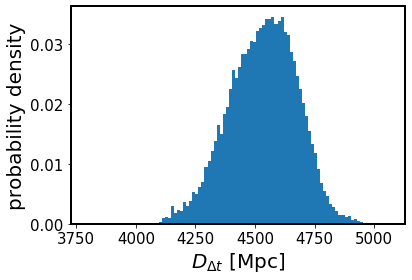

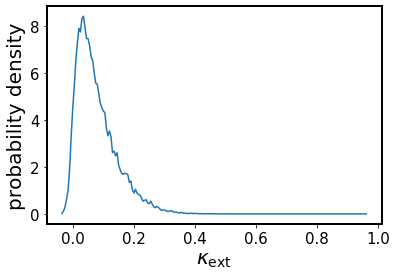

[]


In [5]:
name = 'WFI2033-4723'

ddt_posterior_file = 'wfi2033_pl_dt_nokext.dat'
kappa_ext_file = 'wfi2033_kext_bic_pdf.dat'
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)

# open ddt posterior
output = np.loadtxt(path2ddt, delimiter=',', skiprows=1)
# open kappa_ext posterior
ddt_samples = output[:, 0]
ddt_weights = output[:, 1]

plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


output = np.loadtxt(path2kappa, delimiter=',', skiprows=1)
kappa_sample = output[:, 0]
kappa_weights = weights=output[:, 1]

kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=200, density=True)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()

if name in recompute_lenses:
    kwargs_posterior = process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model)

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()
else:
    print(recompute_lenses)

## SDSS1206+4332

Discovery presented in [Oguri et al. 2005](https://ui.adsabs.harvard.edu/abs/2005ApJ...622..106O/abstract)

Imaging modeling presented in [Birrer et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.4726B/abstract)

Velocity dispersion measurement from Keck-DEIMOS presented in [Agnello et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.458.3830A/abstract)
withg $290 \pm 30$ km/s including systematics.


Time-delay measurement presented in [Eulares et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...553A.121E/abstract)

LOS analysis presented in [Birrer et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.4726B/abstract)

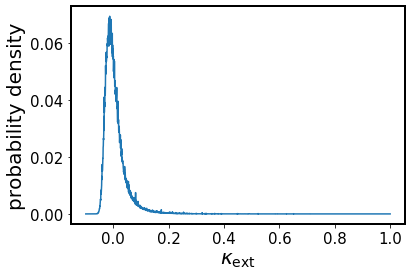

-0.0034149295629985503 median kappa_ext
16924 len kappa_pert


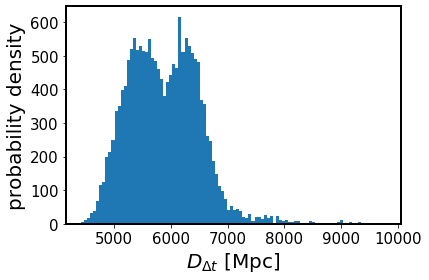

5845.569790766051 626.047197726063


In [6]:
name = 'SDSS1206+4332'
z_d = 0.745

ddt_posterior_file = 'angular_diameter_pre_LOS_power_law.txt'

#kappa_ext_file = 'kappahist_J1206_measured_5innermask_noabeta_zgap-1.0_-1.0_fiducial_120_gal_120_zoverr_45_gal_45_zoverr_24_med_increments4_4_4_4.cat'
kappa_ext_file = 'kappahist_J1206_measured_5innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_zoverr_45_gal_45_zoverr_24_med_increments4_4_4_4.cat'
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)

# this is the convergence distribution used in Birrer et al. 2019

kappa_pdf = np.loadtxt(path2kappa)
kappa_bin_edges = np.linspace(start=-0.1, stop=1, num=len(kappa_pdf)+1)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()

from hierarc.Util.distribution_util import PDFSampling
pdf = PDFSampling(pdf_array=kappa_pdf, bin_edges=kappa_bin_edges)
sample = pdf.draw(n=20000)
print(np.median(sample), 'median kappa_ext')

with open(path2ddt, 'rb') as f:
    out = pickle.load(f, encoding='latin1') 

#f = open(path2ddt)
#out = pickle.load(f, encoding='latin-1')  #
#f.close()
Dd_ds_dds_samples, D_d_samples, kappa_pert = out

print(len(kappa_pert), 'len kappa_pert')
# kappa_pert is to avoid double counting of mass already accounted in the external convergence estimation
Dd_ds_dds_samples /= (1 + kappa_pert)

ddt_samples = Dd_ds_dds_samples * (1 + z_d)
ddt_weights = None

ddt_samples = ddt_samples[ddt_samples > 0]
plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()
print(np.median(ddt_samples), np.std(ddt_samples))

if name in recompute_lenses:
    kwargs_posterior = process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model)

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()

## DES0408-5354

Discovery presented in [Lin et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...838L..15L/abstract)
and [Diehl et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..232...15D/abstract)

Imaging modeling presented in [Shajib et al. 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.1051S/abstract)

Velocity dispersion measurement from GEMINI, Magellan and MUSE presented in [Buckley-Geer et al. 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200312117B/abstract)
Data from Table 3 in [Shajib et al. 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.1051S/abstract) without systematics and a covariant added systematic uncertainty of $\pm 17$ km/s (following [Shajib et al. 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.1051S/abstract) without systematics)


Time-delay measurement presented in [Courbin et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...609A..71C/abstract)

LOS analysis presented in [Buckley-Geer et al. 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200312117B/abstract)



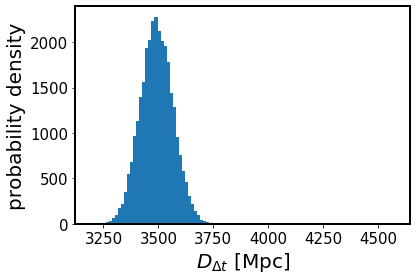

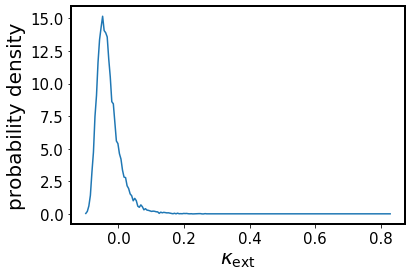

In [7]:
name = 'DES0408-5354'

ddt_posterior_file = 'power_law_dist_post_no_kext.txt'
kappa_ext_file = 'kext_sampled.txt'
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)

# open ddt posterior
ddt_samples = np.loadtxt(path2ddt, delimiter=',', skiprows=1)
ddt_weights = None

plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()

# open kappa_ext posterior
kappa_sample = np.loadtxt(path2kappa, delimiter=',', skiprows=1)
kappa_weights = None

kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=200, density=True)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


# here we specify in the 4 different spectroscopic observations from Buckley-Geer et al., presented in Shajib et al. 2020 Table 3

# Magellan mask A
kwargs_aperture_mag_A = {'aperture_type': 'slit', 'length': 1, 'width': 1, 'center_ra': 0.0, 'center_dec': 0, 'angle': 99/360.*2 * np.pi}
kwargs_seeing_mag_A = {'psf_type': 'MOFFAT', 'fwhm': 0.68, 'moffat_beta': 2.97}
sigma_v_mag_A = 230
sigma_v_sigma_mag_A = 37

# Magellan mask B
kwargs_aperture_mag_B = {'aperture_type': 'slit', 'length': 1, 'width': 1, 'center_ra': 0.0, 'center_dec': 0, 'angle': 99/360.*2 * np.pi}
kwargs_seeing_mag_B = {'psf_type': 'MOFFAT', 'fwhm': 0.76, 'moffat_beta': 3.20}
sigma_v_mag_B = 236
sigma_v_sigma_mag_B = 42

# Gemini mask A2
kwargs_aperture_gemini = {'aperture_type': 'slit', 'length': 0.75, 'width': 1, 'center_ra': 0.0, 'center_dec': 0, 'angle': 0}
kwargs_seeing_gemini = {'psf_type': 'MOFFAT', 'fwhm': 0.52, 'moffat_beta': 3.06}
sigma_v_gemini = 220
sigma_v_sigma_gemini = 21

# MUSE
kwargs_aperture_muse = {'aperture_type': 'slit', 'length': 1, 'width': 1, 'center_ra': 0.0, 'center_dec': 0, 'angle': 0}
kwargs_seeing_muse = {'psf_type': 'MOFFAT', 'fwhm': 0.61, 'moffat_beta': 1.55}
sigma_v_muse = 227
sigma_v_sigma_muse = 9

sigma_v = [sigma_v_mag_A, sigma_v_mag_B, sigma_v_gemini, sigma_v_muse]
sigma_v_error_independent = [sigma_v_sigma_mag_A, sigma_v_sigma_mag_B, sigma_v_sigma_gemini, sigma_v_sigma_muse]
kwargs_aperture_list = [kwargs_aperture_mag_A, kwargs_aperture_mag_B, kwargs_aperture_gemini, kwargs_aperture_muse]
kwargs_seeing_list = [kwargs_seeing_mag_A, kwargs_seeing_mag_B, kwargs_seeing_gemini, kwargs_seeing_muse]

if name in recompute_lenses:
    with open(table_file_path, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            name_lens = row['name']
            if name_lens == name:
                z_lens = float(row['z_lens'])
                kwargs = {'z_lens': float(row['z_lens']), 'z_source': float(row['z_source']),
                          'r_eff': float(row['r_eff']), 'r_eff_error': float(row['r_eff_error']),
                          'theta_E': float(row['theta_E']), 'theta_E_error': float(row['theta_E_error']),
                          'gamma': float(row['gamma']), 'gamma_error': float(row['gamma_error'])}
                kwargs_lens_light, MGE_light, kwargs_mge_light = None, False, None

                ddt_kin = DdtKinConstraints(ddt_samples=ddt_samples, ddt_weights=ddt_weights,
                                 sigma_v=sigma_v, 
                                 sigma_v_error_independent=sigma_v_error_independent, 
                                 sigma_v_error_covariant=17,  #\pm 17 km/s additional template uncertainties
                                 multi_observations=True,
                                 kwargs_aperture=kwargs_aperture_list, kwargs_seeing=kwargs_seeing_list, 
                                 kwargs_numerics_galkin=kwargs_numerics_galkin, 
                                 anisotropy_model=anisotropy_model, kwargs_lens_light=kwargs_lens_light, 
                                 lens_light_model_list=['HERNQUIST'], MGE_light=MGE_light,
                                 kwargs_mge_light=kwargs_mge_light, num_kin_sampling=2000, num_psf_sampling=500, **kwargs)

                kwargs_posterior = ddt_kin.hierarchy_configuration(num_sample_model=num_sample_model_multi_obs)
                kwargs_posterior['name'] = name
                # add external convergence
                kwargs_posterior['kappa_pdf'] = kappa_pdf
                kwargs_posterior['kappa_bin_edges'] = kappa_bin_edges
                kwargs_posterior = dict(**kwargs_posterior, **{'kde_kernel':'gaussian', 'bandwidth':20, 'nbins_hist':100})

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()

## RXJ1131−1231

Discovery presented in [Sluse et al. 2003](https://ui.adsabs.harvard.edu/abs/2003A%26A...406L..43S/abstract)

HST imaging modeling presented in [Suyu et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...788L..35S/abstract).
AO imaging modeling presented in [Chen et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.1743C/abstract)


Velocity dispersion measurement from Keck-LRIS  presented in [Suyu et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...766...70S/abstract)
withg $323 \pm 20$ km/s including systematics.


Time-delay measurement presented in [Tewes et al. 2012](https://ui.adsabs.harvard.edu/abs/2012Msngr.150...49T/abstract)

LOS analysis presented in [Suyu et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...766...70S/abstract)

Independent re-analysis by [Birrer et al. 2016](https://ui.adsabs.harvard.edu/abs/2016JCAP...08..020B/abstract)

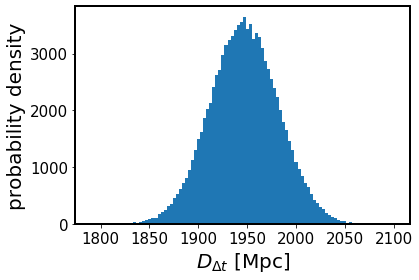

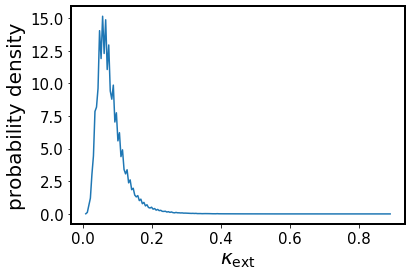

In [8]:
name = 'RXJ1131-1231'

ddt_posterior_file = 'rxj_powerlaw_Ddt.dat'
kappa_ext_file = 'kappa_powerlaw_rxj.dat'
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)

# open ddt posterior
ddt_samples = np.loadtxt(path2ddt, delimiter=',', skiprows=1)
ddt_samples = np.random.choice(ddt_samples, size=100000)  # we select 100'000 posteriors to keep the memory requirement lower
ddt_weights = None
plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


# open kappa_ext posterior
kappa_sample = np.loadtxt(path2kappa, delimiter=',', skiprows=1)
kappa_weights = None




kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=200, density=True)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


if name in recompute_lenses:
    kwargs_posterior = process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model)

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()

## HE0435−1223

Discovery presented in [Wisotzki et al. 2002](https://ui.adsabs.harvard.edu/abs/2002A%26A...395...17W/abstract)


HST imaging modeling presented in [Wong et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.465.4895W/abstract).
AO imaging modeling presented in [Chen et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.1743C/abstract).

Velocity dispersion measurement from Keck-LRIS  presented in [Wong et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.465.4895W/abstract)
withg $222 \pm 15$ km/s including systematics.
Independent measurement by [Courbin et al. 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...536A..53C/abstract) with VLT in excellent agreement $222 \pm 34$ km/s.


Time-delay measurement presented in [Bonvin et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...585A..88B/abstract)

LOS analysis presented in [Rusu et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.467.4220R/abstract)

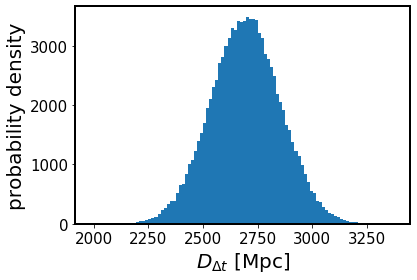

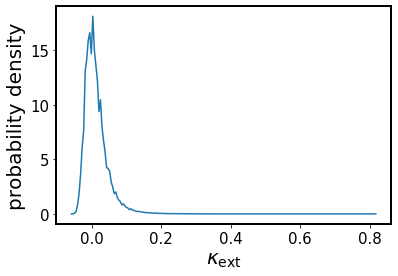

In [9]:
name = 'HE0435-1223'


ddt_posterior_file = 'he_powerlaw_Ddt.dat'
kappa_ext_file = 'kappa_powerlaw_he.dat'
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)

# open ddt posterior
ddt_samples = np.loadtxt(path2ddt, delimiter=',', skiprows=1)
ddt_samples = np.random.choice(ddt_samples, size=100000)  # we select 100'000 posteriors to keep the memory requirement lower


ddt_weights = None

# open kappa_ext posterior
kappa_sample = np.loadtxt(path2kappa, delimiter=',', skiprows=1)
kappa_weights = None

plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=200, density=True)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()

if name in recompute_lenses:
    kwargs_posterior = process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model)

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()

## PG1115+080


Discovery presented in [Weymann et al. 1980](https://ui.adsabs.harvard.edu/abs/1980Natur.285..641W/abstract).


AO imaging modeling presented in [Chen et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.1743C/abstract).

Velocity dispersion measurement from Keck-LRIS  presented in [Tonry et al. 1998](https://ui.adsabs.harvard.edu/abs/1998AJ....115....1T/abstract)
withg $281 \pm 25$ km/s!.


Time-delay measurement presented in [Bonvin et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A.183B/abstract).

LOS analysis presented in [Chen et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.1743C/abstract).


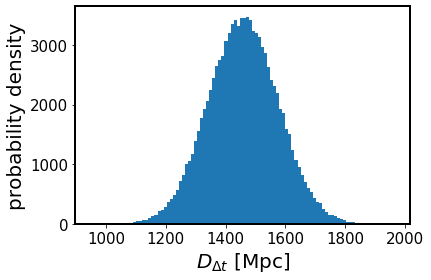

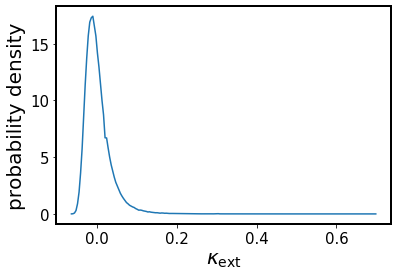

In [10]:
name = 'PG1115+080'


ddt_posterior_file = 'pg_powerlaw_Ddt.dat'
kappa_ext_file = 'kappa_powerlaw_pg.dat'
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)

# open ddt posterior
ddt_samples = np.loadtxt(path2ddt, delimiter=',', skiprows=1)
ddt_samples = np.random.choice(ddt_samples, size=100000)  # we select 100'000 posteriors to keep the memory requirement lower
ddt_weights = None

# open kappa_ext posterior
kappa_sample = np.loadtxt(path2kappa, delimiter=',', skiprows=1)
kappa_weights = None

plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=200, density=True)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


# here we specify the spectroscopic measurement by Tonry et al. and the two MUSE apertures

# Tonry et al.
kwargs_aperture_tonry = {'aperture_type': 'slit', 'length': 1.06, 'width': 1, 'center_ra': 0.0, 'center_dec': 0, 'angle': 0}
kwargs_seeing_tonry = {'psf_type': 'GAUSSIAN', 'fwhm': 0.8}
sigma_v_tonry = 281
sigma_v_sigma_tonry = 25

# MUSE inner aperture
kwargs_aperture_inner = {'aperture_type': 'slit', 'length': 0.6, 'width': 0.6, 'center_ra': 0.0, 'center_dec': 0, 'angle': 99/360.*2 * np.pi}
kwargs_seeing_inner = {'psf_type': 'GAUSSIAN', 'fwhm': 0.67}
sigma_v_inner = 277
sigma_v_sigma_inner = 6.5

# MUSE outer aperture
kwargs_aperture_outer = {'aperture_type': 'frame', 'width_outer': 1.0, 'width_inner': 0.6, 'center_ra': 0.0, 'center_dec': 0, 'angle': 0}
kwargs_seeing_outer = {'psf_type': 'GAUSSIAN', 'fwhm': 0.67}
sigma_v_outer = 241
sigma_v_sigma_outer = 8.8

sys_sigma_muse = 23.6

error_cov_measurement = np.diag([sigma_v_sigma_tonry**2, sigma_v_sigma_inner**2, sigma_v_sigma_outer**2])
error_cov_measurement[1:, 1:] += sys_sigma_muse**2  # we assign the systematics term in the MUSE data as fully covariant among the two apertures

sigma_v = [sigma_v_tonry, sigma_v_inner, sigma_v_outer]
kwargs_aperture_list = [kwargs_aperture_tonry, kwargs_aperture_inner, kwargs_aperture_outer]
kwargs_seeing_list = [kwargs_seeing_tonry, kwargs_seeing_inner, kwargs_seeing_outer]



if name in recompute_lenses:
    with open(table_file_path, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            name_lens = row['name']
            if name_lens == name:
                z_lens = float(row['z_lens'])
                kwargs = {'z_lens': float(row['z_lens']), 'z_source': float(row['z_source']),
                          'r_eff': float(row['r_eff']), 'r_eff_error': float(row['r_eff_error']),
                          'theta_E': float(row['theta_E']), 'theta_E_error': float(row['theta_E_error']),
                          'gamma': float(row['gamma']), 'gamma_error': float(row['gamma_error'])}
                kwargs_lens_light, MGE_light, kwargs_mge_light = None, False, None

                ddt_kin = DdtKinConstraints(ddt_samples=ddt_samples, ddt_weights=ddt_weights,
                                 sigma_v=sigma_v, 
                                 sigma_v_error_independent=np.zeros_like(sigma_v), # we add the covariance matrix manually afterwards
                                 sigma_v_error_covariant=0,
                                 multi_observations=True,
                                 kwargs_aperture=kwargs_aperture_list, kwargs_seeing=kwargs_seeing_list, 
                                 kwargs_numerics_galkin=kwargs_numerics_galkin, 
                                 anisotropy_model=anisotropy_model, kwargs_lens_light=kwargs_lens_light, 
                                 lens_light_model_list=['HERNQUIST'], MGE_light=MGE_light,
                                 kwargs_mge_light=kwargs_mge_light, num_kin_sampling=2000, num_psf_sampling=500, **kwargs)

                kwargs_posterior = ddt_kin.hierarchy_configuration(num_sample_model=num_sample_model_multi_obs)
                kwargs_posterior['name'] = name
                # add external convergence
                kwargs_posterior['kappa_pdf'] = kappa_pdf
                kwargs_posterior['kappa_bin_edges'] = kappa_bin_edges
                kwargs_posterior = dict(**kwargs_posterior, **{'kde_kernel':'gaussian', 'bandwidth':20, 'nbins_hist':100})
                kwargs_posterior['error_cov_measurement'] = error_cov_measurement

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()




if False:
    if name in recompute_lenses:
        kwargs_posterior = process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model)

        path2output = os.path.join(path2processed, name+'_processed.pkl')
        file = open(path2output, 'wb')
        pickle.dump(kwargs_posterior, file)
        file.close()

## B1606+656


Discovery in the Cosmic Lens All-Sky Survey (CLASS) presented in [Myers et al. 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...447L...5M/abstract).


Imaging modeling presented in [Suyu et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...691..277S/abstract) and [Suyu et al. 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...711..201S/abstract).

Velocity dispersion measurement from Keck-LRIS presented in [Suyu et al. 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...711..201S/abstract).
withg $260$ km/s. Statistical uncertainty is $ \pm 7.7$km/s with a spread of $\pm 13$km/s depending on wavelenght and stellar template solution. Joint uncertainty is $260 \pm 15$km/s.
Previous measurement by [Koopmans et al. 2003](https://ui.adsabs.harvard.edu/abs/2003ApJ...599...70K/abstract) with $247 \pm 35$ km/s with ESI on Keck-II.


Time-delay measurement presented in [Fassnacht et al. 1999](https://ui.adsabs.harvard.edu/abs/1999ApJ...527..498F/abstract),
[Fassnacht et al. 2002](https://ui.adsabs.harvard.edu/abs/2002ApJ...581..823F/abstract).

LOS analysis presented in [Suyu et al. 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...711..201S/abstract).

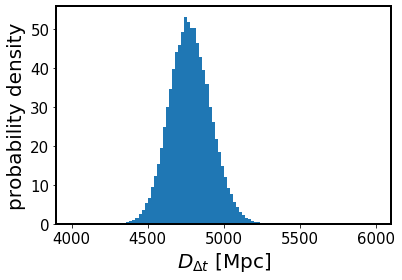

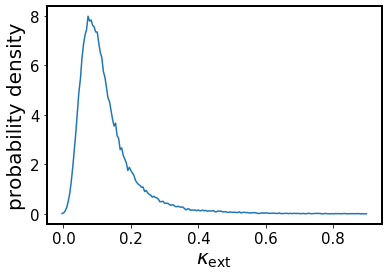

In [11]:
name = 'B1608+656'

ddt_posterior_file = 'B1608_Dtmod_n5e5.dat'
kappa_ext_file = 'B1608_kext.txt'
path2kappa = os.path.join(path2posteriors, name, kappa_ext_file)
path2ddt = os.path.join(path2posteriors, name, ddt_posterior_file)

# open ddt posterior
# wht, Dt^mod, gamma', kappa_ext
output = np.loadtxt(path2ddt, delimiter='\t', skiprows=1)
ddt_samples = output[:, 1]
ddt_weights = output[:, 0]


# open kappa_ext posterior
kappa_sample = np.loadtxt(path2kappa)
kappa_weights = None

plt.hist(ddt_samples, weights=ddt_weights, bins=100)
plt.xlabel(r"$D_{\Delta t}$ [Mpc]", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()


kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=200, density=True)
plt.plot(kappa_bin_edges[1:], kappa_pdf)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.show()

if name in recompute_lenses:
    kwargs_posterior = process_posterior(name, ddt_samples, ddt_weights, kappa_pdf, kappa_bin_edges, num_sample_model)

    path2output = os.path.join(path2processed, name+'_processed.pkl')
    file = open(path2output, 'wb')
    pickle.dump(kwargs_posterior, file)
    file.close()



## Sampling individual chains and joint constraints to reproduce H0LiCOW results


In [12]:

run_chains = False  # boolean, if True, runs the chains, else uses the stored chains to do the plotting 
continue_from_backend = True  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch 

#lambda_slope = False  # allow for linear scaling of lambda_int with r_eff/theta_E

num_distribution_draw = 200

n_walkers = 100
n_run = 200  # 200
n_burn = 400  # 400


tdcosmo_posterior_list = []
for tdcosmo_lens in TDCOSMO_lenses:
    td_cosmo_file_name = os.path.join(path2processed, tdcosmo_lens+'_processed.pkl')
    file = open(td_cosmo_file_name, 'rb')
    posterior = pickle.load(file)
    file.close()
    posterior['num_distribution_draws'] = num_distribution_draw
    posterior['error_cov_measurement'] = np.array(posterior['error_cov_measurement'], dtype='float')
    theta_E, r_eff = properties(tdcosmo_lens, partial_name=True)
    posterior['lambda_scaling_property'] = r_eff/theta_E - 1
    tdcosmo_posterior_list.append(posterior)



0.03775445816314696 0.01994459319190701
0.03775445816314696 0.07419362430002736


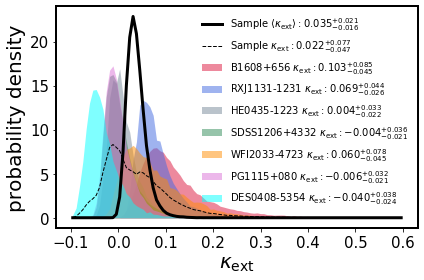

In [13]:
# external convergence distributions
from hierarc.Util.distribution_util import PDFSampling
alpha_kappa = 0.5
percentiles = [16, 50, 84]
quantiles = [0.16, 0.5, 0.84]
colors = ["crimson", "royalblue", "lightslategrey", "seagreen", "darkorange", "orchid", "cyan",  "black"]
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
fmt = "{{0:{0}}}".format(".3f").format
fmt_ddt = "{{0:{0}}}".format(".0f").format
fmt2 = "{{0:{0}}}".format(".2f").format
fmt3 = "{{0:{0}}}".format(".3f").format

exclude_name = []

kappa_pdf_list = []
kappa_name_list = []
for tdcosmo_lens in TDCOSMO_lenses:
    td_cosmo_file_name = os.path.join(path2processed, tdcosmo_lens+'_processed.pkl')
    file = open(td_cosmo_file_name, 'rb')
    posterior = pickle.load(file)
    file.close()
    if posterior['name'] in exclude_name:
        pass
    else:
        ddt_samples = posterior['ddt_samples']
        ddt_weights = posterior['ddt_weights']
        pcs = corner.quantile(ddt_samples, q=quantiles, weights=ddt_weights)
        #txt = title.format(fmt_ddt(pcs[1]), fmt_ddt(pcs[1]-pcs[0]), fmt_ddt(pcs[2]-pcs[1]))
        #print(txt)
        kappa_name_list.append(posterior['name'])
        kappa_pdf_list.append(PDFSampling(bin_edges=posterior['kappa_bin_edges'], pdf_array=posterior['kappa_pdf']))

kappa_bins = np.linspace(start=-0.1, stop=0.6, num=100)    
kappa_samples_list = []
for i, pdf in enumerate(kappa_pdf_list):
    kappa_samples = pdf.draw(n=100000)
    kappa_samples_list.append(kappa_samples)
    pcs = np.percentile(kappa_samples, q=percentiles)
    txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1]-pcs[0]), fmt(pcs[2]-pcs[1]))
    h, be = np.histogram(kappa_samples, bins=kappa_bins, density=True)
    xs = [(b+be[ind+1])/2. for ind, b in enumerate(be[:-1])]
    plt.plot(xs, h, alpha=0.5, color=colors[i], linewidth=0.0)
    plt.fill_between(xs, h, alpha=0.5, color=colors[i], linewidth=0.0, label=kappa_name_list[i] + ' ' + txt)

    # add the values
    
    #plt.annotate(txt, xy=(0.0, 0.0), xytext=(0.02, 0.9-0.085*i), xycoords='axes fraction',
    #                 fontsize=16, color=colors[i])
    
    
    #plt.hist(kappa_samples, bins=kappa_bins, label=kappa_name_list[i], alpha=alpha_kappa, density=True, color=colors[i])
    

kappa_samples_list = np.array(kappa_samples_list)
kappa_means = np.mean(kappa_samples_list, axis=0)
print(np.mean(kappa_means), np.std(kappa_means))

pcs = np.percentile(kappa_means, q=percentiles)
txt = r'$\langle\kappa_{\rm ext}\rangle: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))

h, be = np.histogram(kappa_means, bins=kappa_bins, density=True)
xs = [(b+be[ind+1])/2. for ind, b in enumerate(be[:-1])]
plt.plot(xs, h, alpha=1.0, color=colors[-1], linewidth=3.0, label=r'Sample ' + txt)

kappa_samples_joint = kappa_samples_list.ravel()
print(np.mean(kappa_samples_joint), np.std(kappa_samples_joint))
pcs = np.percentile(kappa_samples_joint, q=percentiles)
txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))

h, be = np.histogram(kappa_samples_joint, bins=kappa_bins, density=True)
xs = [(b+be[ind+1])/2. for ind, b in enumerate(be[:-1])]
plt.plot(xs, h, alpha=1.0, color=colors[-1], linewidth=1.0, linestyle='--', label=r'Sample ' + txt)


plt.legend(frameon=False)
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel("probability density", fontsize=20)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/kappa_ext_tdcosmo.pdf')
plt.show()


In [14]:
cosmology = 'FLCDM'  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

log_scatter = True  # flat prior in log space

# there is also the option to sample the post-newtonian parameter gamma_ppn

beta_inf_min, beta_inf_max = 0, 1
a_ani_min, a_ani_max, a_an_mean = 0.1, 5, 1


kwargs_lower_cosmo = {'h0': 0, 'om': 0.05}
kwargs_lower_lens = {'lambda_mst': 0.5, 'lambda_mst_sigma': 0.001, 'kappa_ext': -0.1, 'kappa_ext_sigma': 0., 'lambda_ifu': 0.5, 'lambda_ifu_sigma': 0.001, 'alpha_lambda': -1}
kwargs_lower_kin = {'a_ani': a_ani_min, 'a_ani_sigma': 0.01, 'beta_inf': beta_inf_min, 'beta_inf_sigma': 0.001, 'sigma_v_sys_error': 0.01}

kwargs_upper_cosmo = {'h0': 150, 'om': 0.5}
kwargs_upper_lens = {'lambda_mst': 1.5, 'lambda_mst_sigma': .5, 'kappa_ext': 0.5, 'kappa_ext_sigma': 0.5, 'lambda_ifu': 1.5, 'lambda_ifu_sigma': 0.5, 'alpha_lambda': 1}
kwargs_upper_kin = {'a_ani': a_ani_max, 'a_ani_sigma': 1. ,'beta_inf': beta_inf_max, 'beta_inf_sigma': 1, 'sigma_v_sys_error': 0.5}

# these values are held fixed throughout the entire sampling (optinal to add here)
kwargs_fixed_cosmo = {}
kwargs_fixed_lens = {}

# for the 'GOM' model is beta_inf should be free or fixed=1
kwargs_fixed_kin = {}


kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {'lambda_mst': 1., 'lambda_mst_sigma': .05, 'lambda_ifu': 1, 'lambda_ifu_sigma': 0.05, 'alpha_lambda': 0},
                     'kwargs_kin': {'a_ani': 1, 'a_ani_sigma': 0.1, 'beta_inf': 0.8, 'beta_inf_sigma': 0.1, 'sigma_v_sys_error': 0.05}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.1},
                     'kwargs_lens': {'lambda_mst': .1, 'lambda_mst_sigma': .05, 'lambda_ifu': 0.1, 'lambda_ifu_sigma': 0.05, 'alpha_lambda': 0.1},
                     'kwargs_kin': {'a_ani': 0.3, 'a_ani_sigma': 0.1, 'beta_inf': 0.5, 'beta_inf_sigma': 0.1, 'sigma_v_sys_error': 0.05}}


class CustomPrior(object):
    def __init__(self, om_prior=True, log_scatter=False):
        self._om_prior = om_prior
        self._log_scatter = log_scatter
        self.om_mean = 0.298
        self.sigma_om = 0.022
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin)
    
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin):

        logL = 0
        # a prior on Omega_m helps in constraining the MST parameter as the kinematics becomes less cosmology dependent...
        if self._om_prior is True:
            om = kwargs_cosmo.get('om', self.om_mean)
            logL += -(om - self.om_mean)**2 / self.sigma_om**2 / 2
        if self._log_scatter is True:
            lambda_mst_sigma = kwargs_lens.get('lambda_mst_sigma', 1)
            logL += np.log(1/lambda_mst_sigma)
            lambda_ifu_sigma = kwargs_lens.get('lambda_ifu_sigma', 1)
            logL += np.log(1/lambda_ifu_sigma)
            a_ani_sigma = kwargs_kin.get('a_ani_sigma', 1)
            logL += np.log(1/a_ani_sigma)
            sigma_v_sys_error = kwargs_kin.get('sigma_v_sys_error', 1)
            logL += np.log(1/sigma_v_sys_error)
            
        a_ani = kwargs_kin.get('a_ani', 1)
        logL += np.log(1/a_ani)
        return logL
    
kwargs_bounds = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                'kwargs_lower_lens': kwargs_lower_lens,
                'kwargs_lower_kin': kwargs_lower_kin,
                'kwargs_upper_cosmo': kwargs_upper_cosmo,
                'kwargs_upper_lens': kwargs_upper_lens,
                'kwargs_upper_kin': kwargs_upper_kin,
                'kwargs_fixed_cosmo': kwargs_fixed_cosmo,
                'kwargs_fixed_lens': kwargs_fixed_lens,
                'kwargs_fixed_kin': kwargs_fixed_kin}

kwargs_sampler = {'lambda_mst_sampling': True,
                 'lambda_mst_distribution': 'GAUSSIAN',
                 'anisotropy_sampling': True,
                 'kappa_ext_sampling': False,
                 'kappa_ext_distribution': 'GAUSSIAN',
                 'sigma_v_systematics': False,
                 'anisotropy_model': anisotropy_model,
                 'anisotropy_distribution': 'GAUSSIAN',
                 #'alpha_lambda_sampling': lambda_slope,
                 'interpolate_cosmo': True, 'num_redshift_interp': 100,
                 #'custom_prior': CustomPrior(om_prior=omega_m_prior, log_scatter=log_scatter)
                 }





In [15]:
# here we sample the tdcosmo data with fixed lambda_mst = 1 for each TDCOSMO lens individually
# this is for testing and reproducibility purpose only

if False:

    for i in range(len(tdcosmo_posterior_list)):
        print(tdcosmo_posterior_list[i]['name'])
        mcmc_sampler_tdcosmo_fixed_lambda = MCMCSampler([tdcosmo_posterior_list[i]], cosmology, kwargs_bounds, ppn_sampling=False,
                         lambda_mst_sampling=False, lambda_mst_distribution='GAUSSIAN', anisotropy_sampling=True,
                                   kappa_ext_sampling=False, kappa_ext_distribution='GAUSSIAN',
                         anisotropy_model=anisotropy_model, anisotropy_distribution='None', custom_prior=None, interpolate_cosmo=True, num_redshift_interp=100,
                         cosmo_fixed=None)

        mcmc_samples_tdcosmo_fixed_lambd, log_prob_cosmo = mcmc_sampler_tdcosmo_fixed_lambda.mcmc_emcee(n_walkers, n_run, n_burn, kwargs_mean_start, kwargs_sigma_start)

        corner.corner(mcmc_samples_tdcosmo_fixed_lambd, show_titles=True, labels=mcmc_sampler_tdcosmo_fixed_lambda.param_names(latex_style=True))
        plt.show()

In [16]:
# and here we use the 1/a_ani prior while keeping lambda_int fixed, just to check that when keeping lambda_int fixed, the anisotropy prior does not matter
if False:
    mcmc_sampler_tdcosmo_fixed_lambda_ani = MCMCSampler(tdcosmo_posterior_list, cosmology, kwargs_bounds, ppn_sampling=False,
                         lambda_mst_sampling=False, lambda_mst_distribution='GAUSSIAN', anisotropy_sampling=True,
                                   kappa_ext_sampling=False, kappa_ext_distribution='GAUSSIAN',
                         anisotropy_model=anisotropy_model, anisotropy_distribution='GAUSSIAN', custom_prior=CustomPrior(log_ani_prior=True), interpolate_cosmo=True, num_redshift_interp=100,
                         cosmo_fixed=None)

    ndim = mcmc_sampler_tdcosmo_fixed_lambda_ani.param.num_param
    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = "tdcosmo_fixed_lambda_ani_chain.h5"
    backend = emcee.backends.HDFBackend(filename)
    if run_chains is True:
        mcmc_samples_tdcosmo_fixed_lambda_ani, log_prob_cosmo = mcmc_sampler_tdcosmo_fixed_lambda_ani.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                                                 kwargs_mean_start, kwargs_sigma_start, 
                                                                                                                 continue_from_backend=continue_from_backend, backend=backend)
    else:
        mcmc_samples_tdcosmo_fixed_lambda_ani = backend.get_chain(discard=n_burn, flat=True, thin=1)
        log_prob_cosmo = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

    corner.corner(mcmc_samples_tdcosmo_fixed_lambda_ani, show_titles=True, labels=mcmc_sampler_tdcosmo_fixed_lambda_ani.param_names(latex_style=True))
    plt.show()

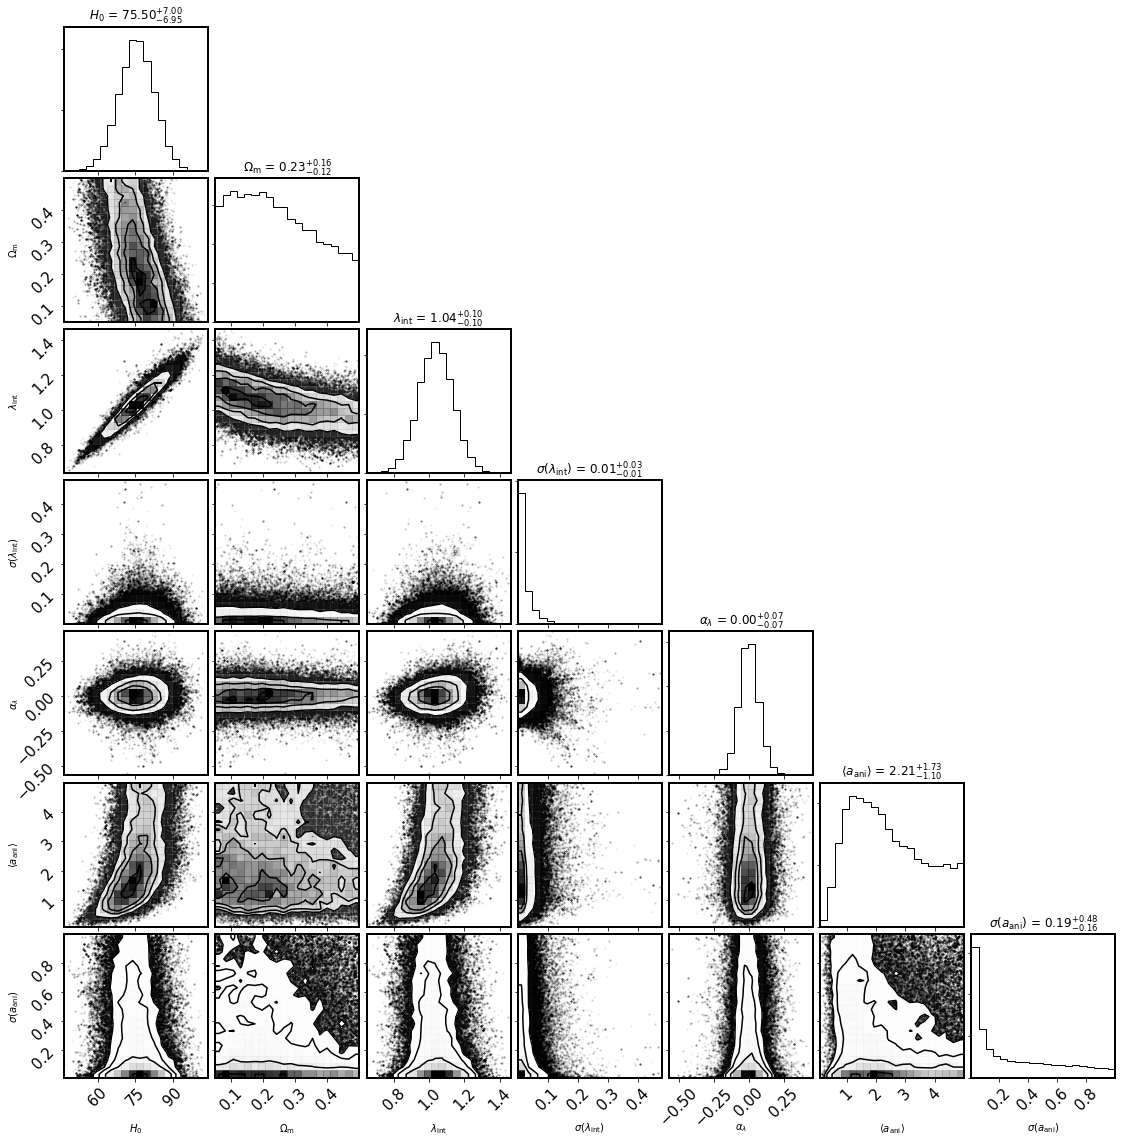

In [17]:
# omega_m free, alpha_lambda free

mcmc_sampler_tdcosmo_alpha_free = MCMCSampler(tdcosmo_posterior_list, cosmology, kwargs_bounds, 
                                              custom_prior=CustomPrior(om_prior=False, log_scatter=log_scatter),
                                              alpha_lambda_sampling=True, **kwargs_sampler)

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tdcosmo_chain_alpha_free.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_tdcosmo_alpha_free, log_prob_cosmo_alpha_free = mcmc_sampler_tdcosmo_alpha_free.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                           kwargs_mean_start, kwargs_sigma_start, 
                                                                           continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_tdcosmo_alpha_free = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_cosmo_alpha_free = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

corner.corner(mcmc_samples_tdcosmo_alpha_free, show_titles=True, labels=mcmc_sampler_tdcosmo_alpha_free.param_names(latex_style=True))
plt.show()

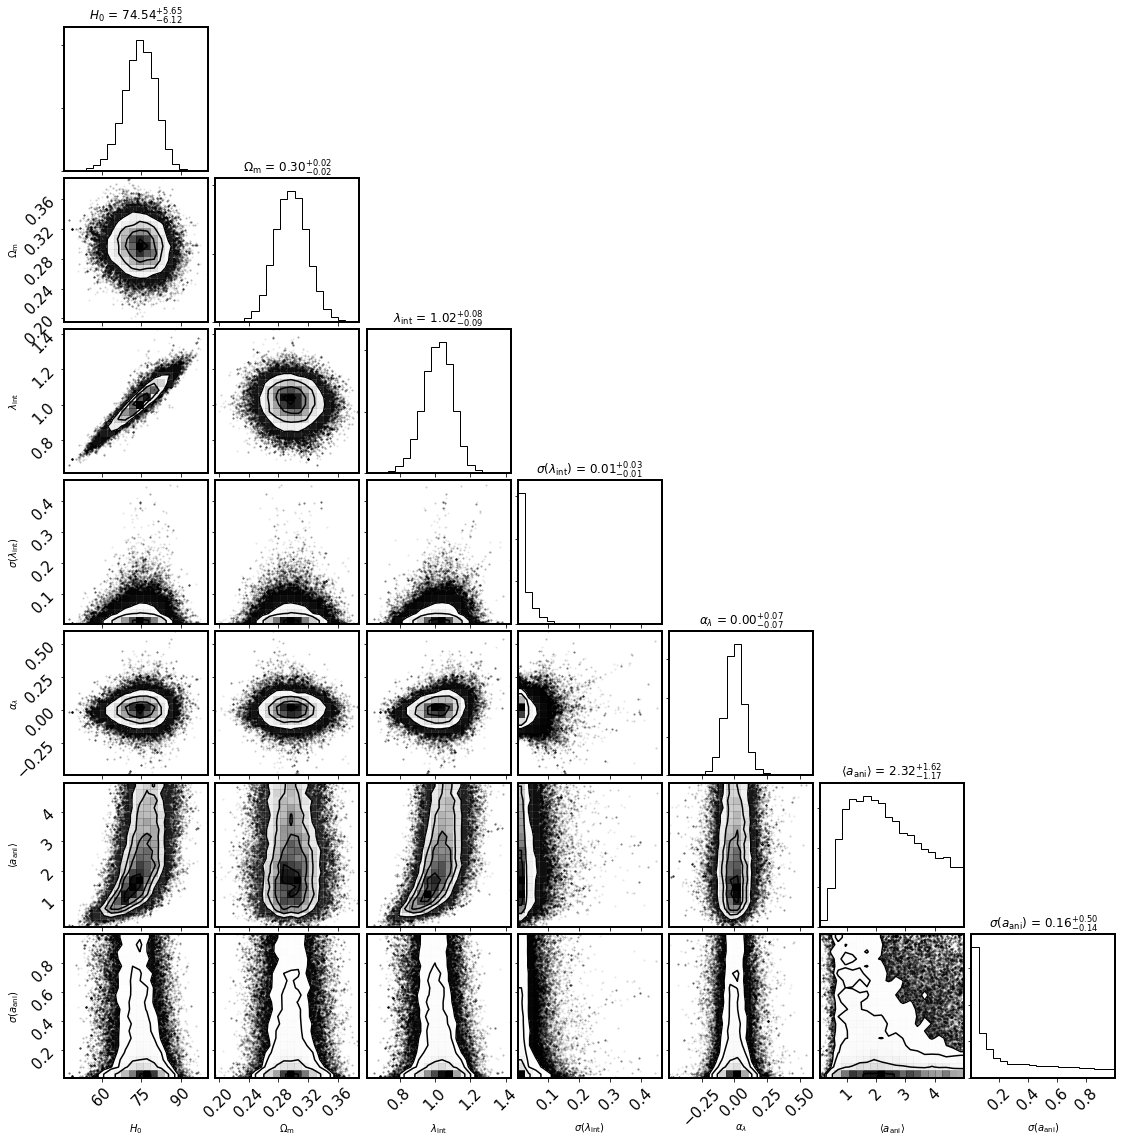

In [18]:
# omega_m tight, alpha_lambda free

mcmc_sampler_tdcosmo_alpha_free_om = MCMCSampler(tdcosmo_posterior_list, cosmology, kwargs_bounds, 
                                                 custom_prior=CustomPrior(om_prior=True, log_scatter=log_scatter), 
                                                 alpha_lambda_sampling=True, **kwargs_sampler)

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tdcosmo_chain_alpha_free_om.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_tdcosmo_alpha_free_om, log_prob_cosmo_alpha_free_om = mcmc_sampler_tdcosmo_alpha_free_om.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                           kwargs_mean_start, kwargs_sigma_start, 
                                                                           continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_tdcosmo_alpha_free_om = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_cosmo_alpha_free_om = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

corner.corner(mcmc_samples_tdcosmo_alpha_free_om, show_titles=True, labels=mcmc_sampler_tdcosmo_alpha_free.param_names(latex_style=True))
plt.show()

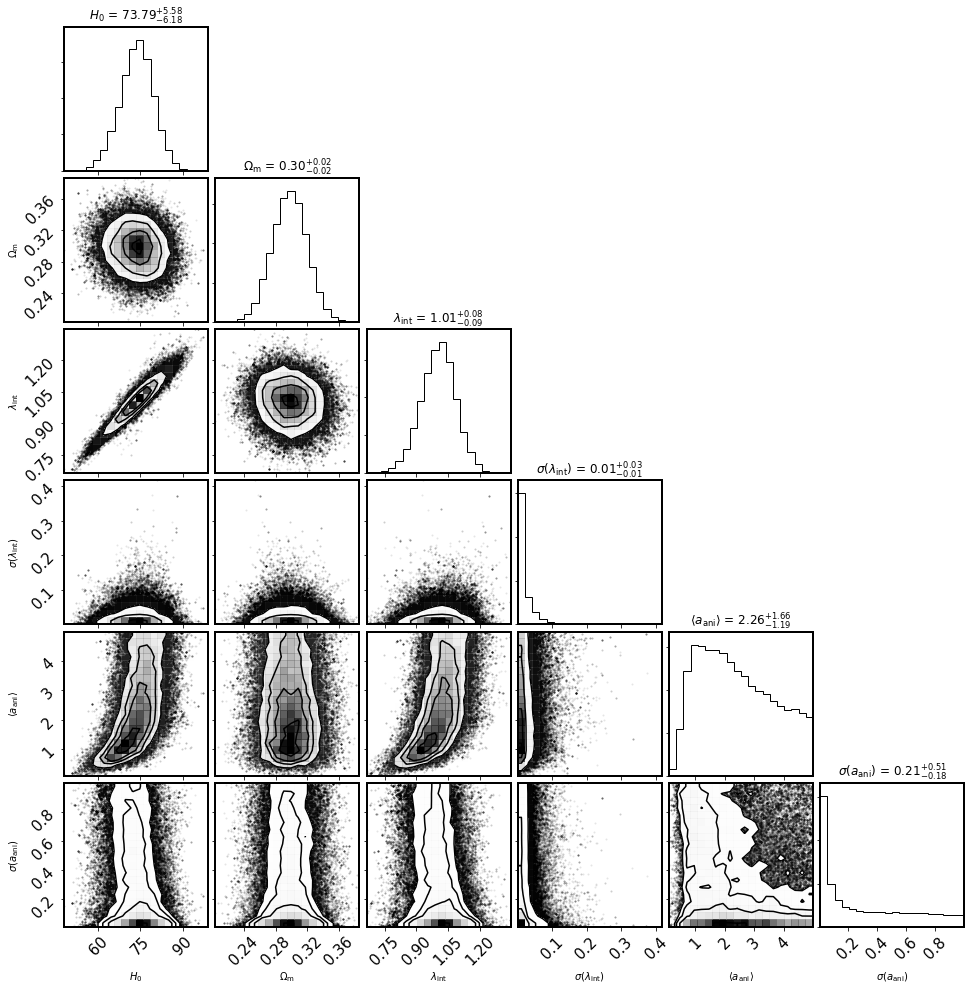

In [19]:
# omega_m tight, alpha_lambda fixed

mcmc_sampler_tdcosmo_alpha_fixed_om = MCMCSampler(tdcosmo_posterior_list, cosmology, kwargs_bounds, 
                                                  custom_prior=CustomPrior(om_prior=True, log_scatter=log_scatter), 
                                                  alpha_lambda_sampling=False, **kwargs_sampler)

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tdcosmo_chain_alpha_fixed_om.h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_tdcosmo_alpha_fixed_om, log_prob_cosmo_alpha_fixed_om = mcmc_sampler_tdcosmo_alpha_fixed_om.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                           kwargs_mean_start, kwargs_sigma_start, 
                                                                           continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_tdcosmo_alpha_fixed_om = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_cosmo_alpha_fixed_om = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

corner.corner(mcmc_samples_tdcosmo_alpha_fixed_om, show_titles=True, labels=mcmc_sampler_tdcosmo_alpha_fixed_om.param_names(latex_style=True))
plt.show()

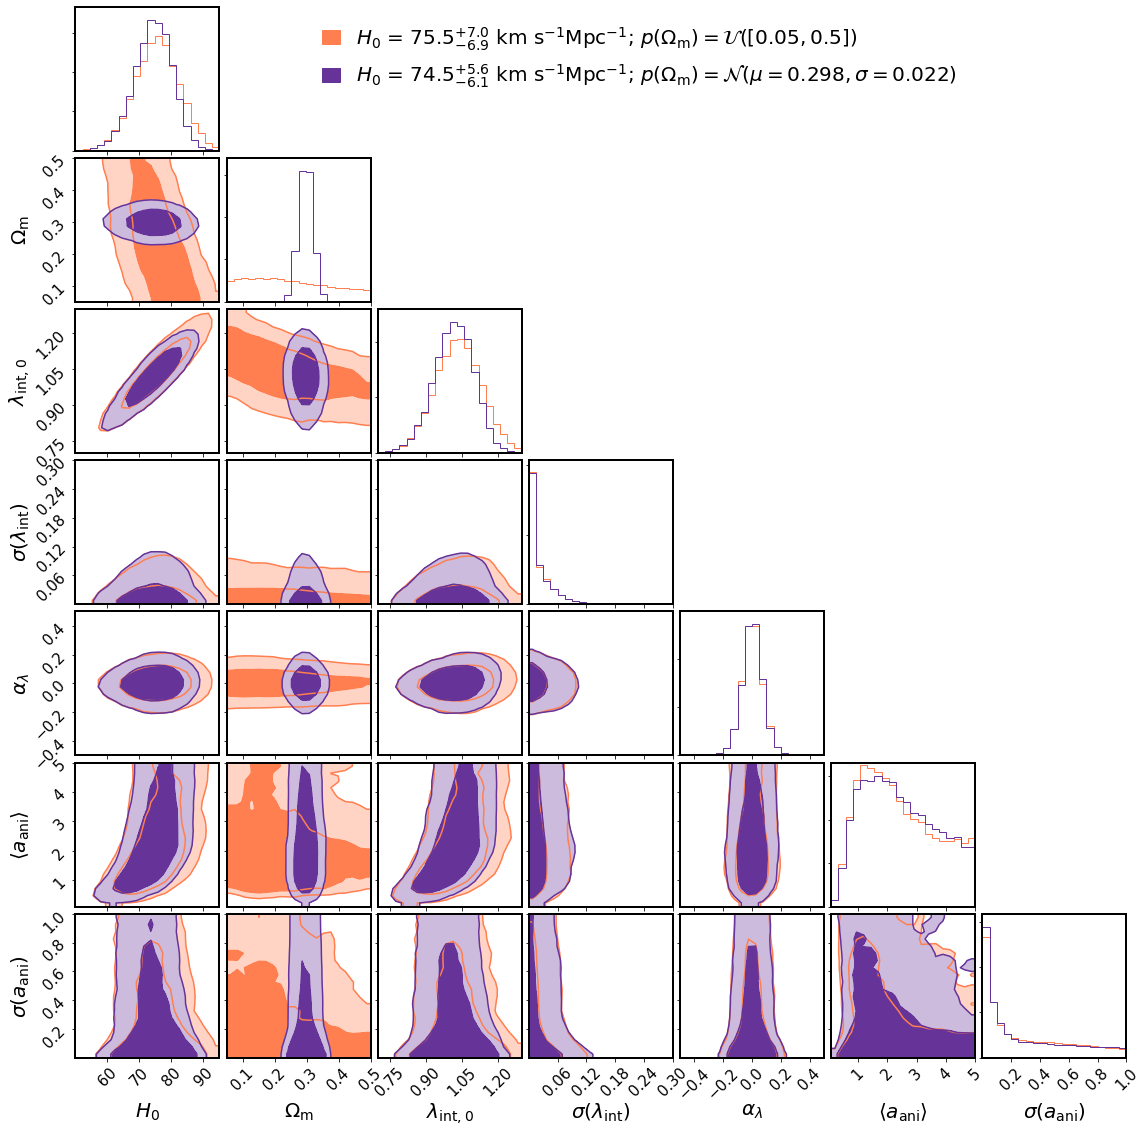

In [20]:
alpha = 1.
from lenstronomy.Plots import plot_util
color_list = ['coral', 'rebeccapurple']

labels=mcmc_sampler_tdcosmo_alpha_free_om.param_names(latex_style=True)
labels[2] = r'$\lambda_{\rm int, 0}$'

log_space_scatter_plot = False  # we make the choice to plot the scatter in log-space
mcmc_samples_tdcosmo_alpha_free_plot = copy.deepcopy(mcmc_samples_tdcosmo_alpha_free)
mcmc_samples_tdcosmo_alpha_free_om_plot = copy.deepcopy(mcmc_samples_tdcosmo_alpha_free_om)

if log_space_scatter_plot:
    mcmc_samples_tdcosmo_alpha_free_plot[:, 3] = np.log10(mcmc_samples_tdcosmo_alpha_free_plot[:, 3])
    mcmc_samples_tdcosmo_alpha_free_plot[:, 6] = np.log10(mcmc_samples_tdcosmo_alpha_free_plot[:, 6])
    mcmc_samples_tdcosmo_alpha_free_om_plot[:, 3] = np.log10(mcmc_samples_tdcosmo_alpha_free_om_plot[:, 3])
    mcmc_samples_tdcosmo_alpha_free_om_plot[:, 6] = np.log10(mcmc_samples_tdcosmo_alpha_free_om_plot[:, 6])


extents = [[50, 95], [0.05, 0.5], [0.7, 1.3], [0, 0.3], [-0.5, 0.5], [0.1, 5], [0, 1]]
if log_space_scatter_plot is True:
    extents = [[50, 95], [0.05, 0.5], [0.7, 1.3], [-3, 0], [-0.5, 0.5], [0.1, 5], [-2, 0]]
    labels[3] = r'$\log_{10}(\sigma(\lambda_{\rm int, 0}))$'
    labels[6] = r'$\log_{10}(\sigma(a_{\rm ani}))$'
    
#extents = None
kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.7, 'smooth1d': None, 
                 'levels': [0.68,0.95], 
                 'labels': labels,
                 'show_titles': False,
                 'label_kwargs': dict(fontsize=20),
                 'fill_contours': True, 'plot_datapoints': False,
                'range': extents}


fig = corner.corner(mcmc_samples_tdcosmo_alpha_free_plot, color=color_list[0], 
                    hist_kwargs= {'density': True, 'color': color_list[0]}, **kwargs_corner)
fig = corner.corner(mcmc_samples_tdcosmo_alpha_free_om_plot, fig=fig, color=color_list[1],
                    hist_kwargs= {'density': True, 'color': color_list[1]}, **kwargs_corner)

result_string_om = plot_util.result_string(mcmc_samples_tdcosmo_alpha_free_om[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')
result_string = plot_util.result_string(mcmc_samples_tdcosmo_alpha_free[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')
patch_1 = mpatches.Patch(color=color_list[0], label=result_string +r' km s$^{-1}$Mpc$^{-1}$' + r'; $p(\Omega_{\rm m}) = \mathcal{U}([0.05, 0.5])$', alpha=alpha)
patch_2 = mpatches.Patch(color=color_list[1], label=result_string_om +r' km s$^{-1}$Mpc$^{-1}$' + r'; $p(\Omega_{\rm m}) = \mathcal{N}(\mu=0.298, \sigma=0.022)$', alpha=alpha)

ax = fig.axes[5]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend(handles=[patch_1, patch_2], fontsize=20, handlelength=0.9, loc=1, frameon=False)


#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/tdcosmo_results_only.pdf')
plt.show()